In [1]:
import sys
from pathlib import Path
ROOT_DIR = Path().resolve().parents[0]
sys.path.append(str(ROOT_DIR))
import config as cfg

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

N_RUN = 1

# Training analysis across folds

In [2]:
def get_checkpoint_steps_from_fold(n_run, fold_id):
    path_fold_dir = os.path.join(cfg.PATH_CHECKPOINTS, cfg.MODEL_BASE, f"run_{n_run}", f"fold_{fold_id}")
    checkpoints = [int(folder.split("checkpoint-")[-1]) for folder in os.listdir(path_fold_dir) if folder.startswith("checkpoint")]
    return sorted(checkpoints)

In [3]:
def get_best_metric_from_fold(n_run, fold_id):
    last_checkpoint = max(get_checkpoint_steps_from_fold(n_run, fold_id))
    path_trainer_state = os.path.join(
        cfg.PATH_CHECKPOINTS, cfg.MODEL_BASE, f"run_{n_run}", f"fold_{fold_id}",
        f"checkpoint-{last_checkpoint}", "trainer_state.json"
    )
    
    try:
        with open(path_trainer_state, "r") as f:
            trainer_state = json.load(f)
        return trainer_state["best_metric"]
    except FileNotFoundError:
        print(f"File not found: {path_trainer_state}")
        return None

In [4]:
# Get the best roc_auc_macro from each fold
fold_scores = {f"fold_{fold_id}_roc_auc_macro": get_best_metric_from_fold(N_RUN, fold_id) for fold_id in range(cfg.N_FOLDS)}
fold_scores

{'fold_0_roc_auc_macro': 0.9908678926045189,
 'fold_1_roc_auc_macro': 0.9884386463511081,
 'fold_2_roc_auc_macro': 0.9901159927044852,
 'fold_3_roc_auc_macro': 0.9900384499025341,
 'fold_4_roc_auc_macro': 0.9907736768239926}

In [5]:
# Calculate the mean roc_auc_macro across all folds
print(f"Mean roc_auc_macro across all folds: {np.mean(list(fold_scores.values()))}")

Mean roc_auc_macro across all folds: 0.9900469316773277


In [6]:
# Calculate the std dev of the roc_auc_macro across all folds
print(f"Std dev roc_auc_macro across all folds: {np.std(list(fold_scores.values()))}")

Std dev roc_auc_macro across all folds: 0.0008710405741048608


## Conclusions

The ROC AUC macro scores across the five folds are very high, with a mean of approximately 0.990057.

Moreover, the small standard deviation (~0.001430) indicates minimal variation between the folds. This suggests not only that the model performs well when generalizing, but also that these strong results are not dependent on any particular data split.

We can conclude that the model generalizes exceptionally well.

# Learning and ROC-AUC curves

## Get data for plots

In [7]:
# Calculate the number of steps per epoch, to then calculate the epoch
steps_per_epoch = 3990

In [8]:
df = pd.DataFrame()
for fold_id in range(cfg.N_FOLDS):
	path_fold_results = os.path.join(cfg.PATH_RESULTS, "evaluation", f"run_{N_RUN}", f"fold_{fold_id}.txt")
	df_fold = pd.read_csv(path_fold_results, sep="\t")
	df_fold["epoch"] = df_fold["step"] / steps_per_epoch
	df_fold["fold"] = fold_id
	df_fold.insert(0, "fold", df_fold.pop("fold"))
	df_fold.insert(2, "epoch", df_fold.pop("epoch"))
	df = pd.concat([df, df_fold], ignore_index=True)
df.rename(columns={"roc_auc_macro": "val_roc_auc_macro"}, inplace=True)
df

,fold,step,epoch,train_loss,val_loss,val_roc_auc_macro
0,0,500,0.125313,0.0528,0.048624,0.969358
1,0,1000,0.250627,0.0535,0.049696,0.978421
2,0,1500,0.375940,0.0460,0.043548,0.981134
3,0,2000,0.501253,0.0487,0.043338,0.982133
4,0,2500,0.626566,0.0447,0.041547,0.982710
...,...,...,...,...,...,...
99,4,9500,2.380952,0.0309,0.037561,0.990580
100,4,10000,2.506266,0.0312,0.037101,0.990417
101,4,10500,2.631579,0.0309,0.037878,0.990774
102,4,11000,2.756892,0.0283,0.037178,0.990645


## Plot results

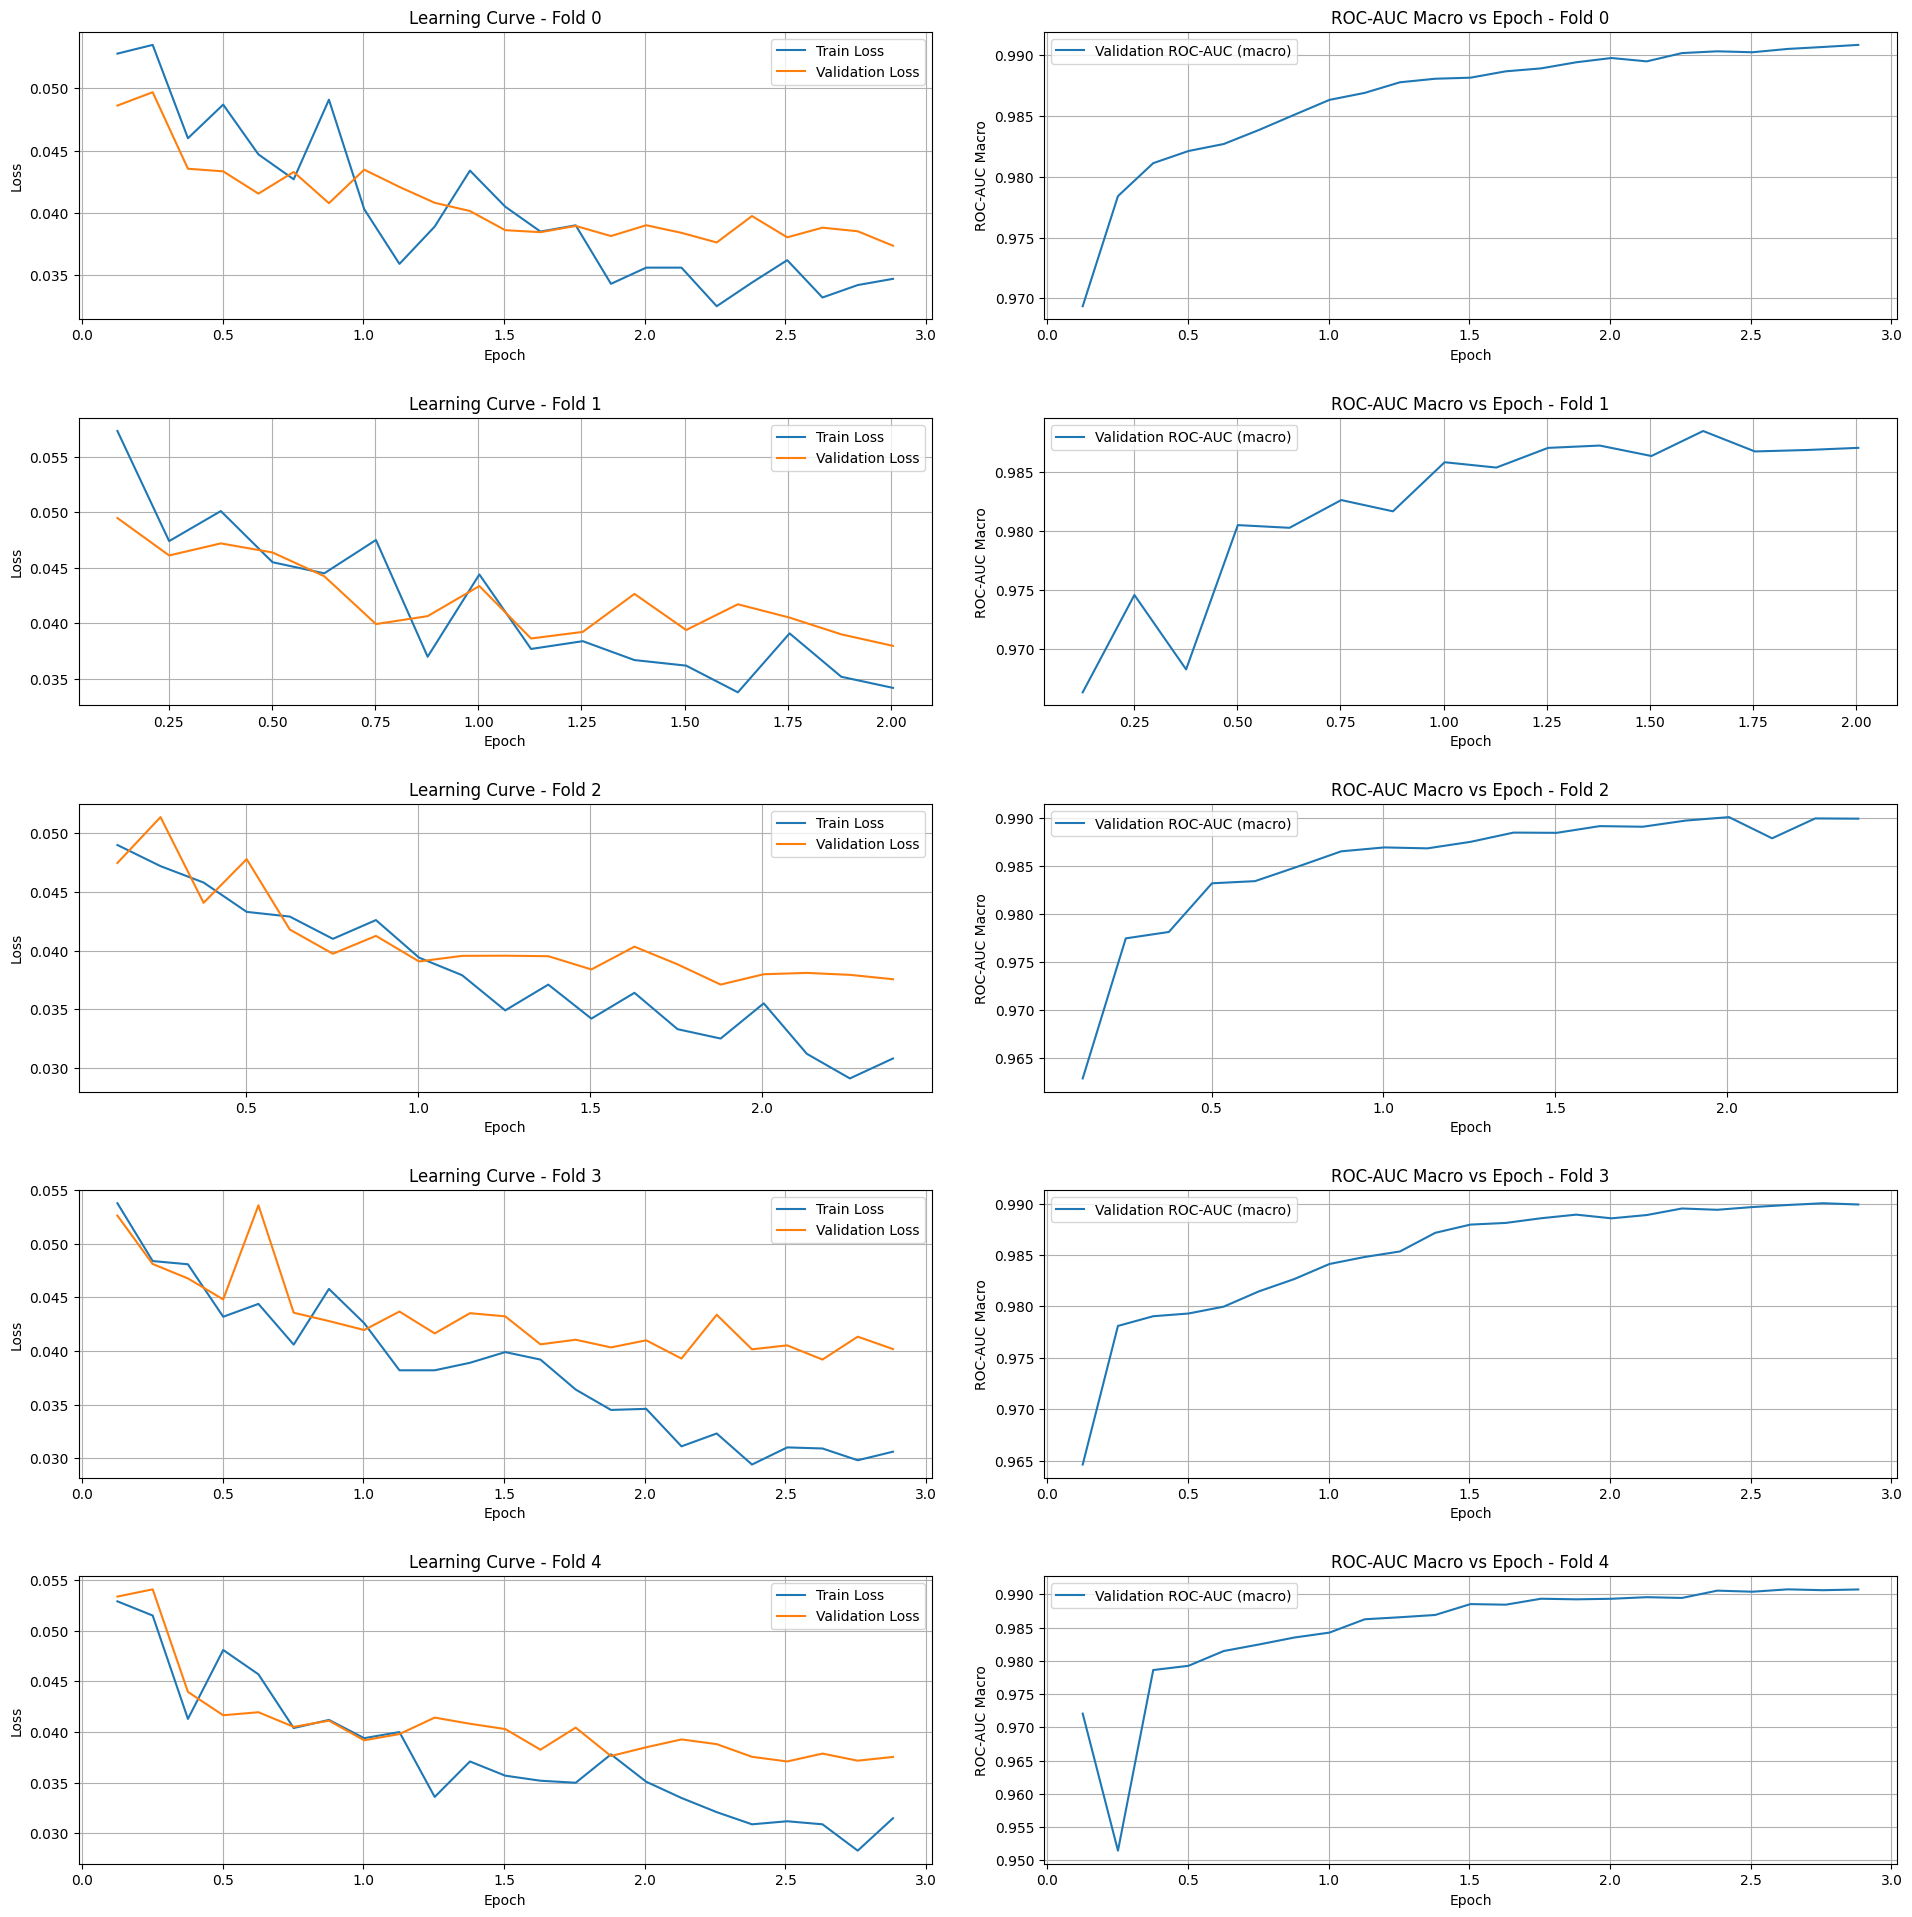

In [9]:
fig, axes = plt.subplots(nrows=cfg.N_FOLDS, ncols=2, figsize=(20, 20))
fig.tight_layout(pad=5.0)

for fold_id in range(cfg.N_FOLDS):
    # Filter data based on fold_id
    df_fold = df[df["fold"] == fold_id]

    # Get x axes
    ax_loss = axes[fold_id, 0]
    ax_auc = axes[fold_id, 1]

    # Firs plot: train_loss and val_loss vs epoch
    ax_loss.plot(df_fold["epoch"], df_fold["train_loss"], label="Train Loss")
    ax_loss.plot(df_fold["epoch"], df_fold["val_loss"], label="Validation Loss")
    ax_loss.set_title(f"Learning Curve - Fold {fold_id}")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()
    ax_loss.grid(True)

    # Second plot: val_roc_auc_macro vs epoch
    ax_auc.plot(df_fold["epoch"], df_fold["val_roc_auc_macro"], label="Validation ROC-AUC (macro)")
    ax_auc.set_title(f"ROC-AUC Macro vs Epoch - Fold {fold_id}")
    ax_auc.set_xlabel("Epoch")
    ax_auc.set_ylabel("ROC-AUC Macro")
    ax_auc.legend()
    ax_auc.grid(True)

# Show all the plots
plt.show()

## Conclusions

TBD